# Experimental step response of a series RLC circuit. 

$~~~~~~$

<div style='text-align: justify;'>
This programming book presents the procedure and code for obtaining the response to the step of a series RLC circuit. The  comparing the experiemental results to a simulation made using the MatLab kernel. The circuit is made up of a 127 to 12 volt transformer with a maximum output current of 0.25 Amp whose primary coil is the one used as the inductance of 15.1 $H$. The resistor is a 5 $K\Omega$ potentiometer and the capacitor is 1 $\mu F$ electrolytic. The step has an amplitude of 1.63 Volts generated through the digital-analog converter of an Arduino Due board. The mentioned elements are shown in the figure below.
</div>

$~~~~~~$

<center>
<img src="images/RLC.jpg" width="300"/>
</center>

###  The following lines are necessary to establish communication with the Arduino bard, next, to stablish the number of samples to acquire:

$~~~~~~$

<center>
<img src="images/diagrama_USB_ingles.jpg" width="600"/>
</center>


In [1]:
clear
close all
n_samples=2^10;
sampling_freq=5000;
s = serialport("COM5",2000000,"Timeout",5);

### Once USB communication is established, the numerical value of the number of samples to be taken and the sampling frequency is sent. The data acquisition is done by executing the following lines.

In [2]:
writeline(s,string(n_samples)+ '\n' + string(sampling_freq) + '\n')
disp('Acquiring data.');
data=[];

for i=1:n_samples/256
    data=[data read(s,512,"uint16")];
    disp('.');
end 

disp('Data aquisition done... Data ready for processing.');

Acquiring data.
.
.
.
.
Data aquisition done... Data ready for processing.


### The transfer function of the system is:
 \begin{equation}
 \frac{V_C(s)}{V_s(s)}=\frac{\frac{1}{LC}}{\left(s^2+\frac{R}{L}s+\frac{1}{LC}\right)}
 \end{equation}

In [3]:
R=1600;
C=1.1*(10^(-6));
L=15.1;

num=[1.645/(L*C)];
den=[1 R/L 1/(L*C)];
G=tf(num,den)


G =
 
        9.904e04
  ---------------------
  s^2 + 106 s + 6.02e04
 
Continuous-time transfer function.


### Thus, the step response of the RLC circuit transfer function is simulated and compared to the experimental data.

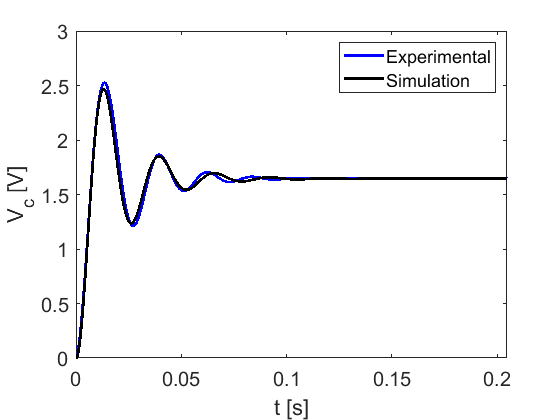

In [4]:
t=[0:1/sampling_freq:(n_samples-1)*(1/sampling_freq)];
adq=data(find(data<(2^13)));
clear device
v_c=((3.3/4095)*adq);
plot(t,v_c,"-b",'LineWidth',2)
hold on
grid
[y,to]=step(G,t);

plot(to,y,'-k','LineWidth',2)
grid
axis([0 1*max(t),0 3]) 
legend('Experimental','Simulation')
xlabel('t [s]')
ylabel('V_c [V]')
set(gca,'FontSize',15)

### In the following lines, the Bode diagram of the transfer function is compared to the FFT of the experimental data 

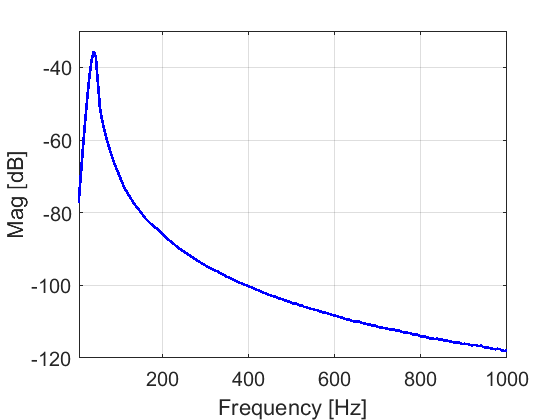

In [5]:
n=(size(t));% número total de muestras a utilizar
NFFT = 2^nextpow2(max(n));% resolución óptima para el cálculo de la FFT
f = (sampling_freq/2).*linspace(0,1,NFFT/2);

Y= fft((v_c-mean(v_c)),NFFT)/(max(n)/2);%Calculo de la FFT, x es el nombre del vector de salida
r=Y(1:NFFT/2);%solo se toma la parte de las frecuencias positivas es decir, la mitad del espectro
 
figure
plot(f,20*log(abs(r)),'-b','LineWidth',2) % se grafica la magnitud contra la frecuencia.

hold on
axis([5 1000,-120 -30]) 
grid
 
xlabel('Frequency [Hz]')
ylabel('Mag [dB]')
set(gca,'FontSize',15)


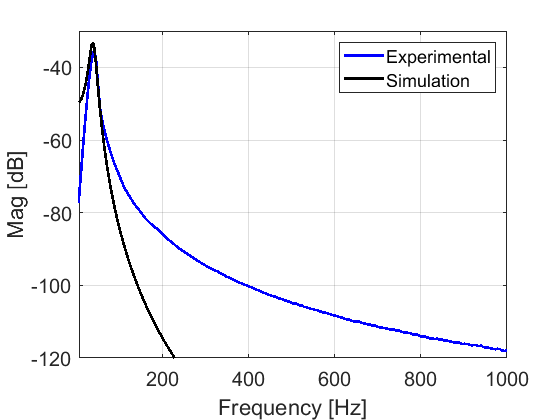

In [6]:
[mag,ph,w]=bode(G,f*2*pi);
dB=[];

for i=1:1:max(size(mag))
    dB(i)=20*log(mag(1,1,i))-60;
end  

plot(f,dB,'-k','LineWidth',2)
legend('Experimental','Simulation')